<a href="https://colab.research.google.com/github/lorek/MethodsClassDimRed/blob/main/MoCaDR_List_nr_3_PCA_SVD_NCA_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Methods of classification and dimensionality reduction**


Paweł Lorek  
University of Wrocław

# LIST NR 3: PCA, SVD, NCA, ICA

 <font face="Rage" size=2  > Updated: 21.03.2025 <font>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import decomposition
import torch

import imageio

**MNIST dataset** (again)

In [ ]:
mnist = datasets.load_digits()
max_n=600
mnist_points =        mnist.data[:max_n]
mnist_labels =  mnist.target[:max_n]
mnist_classes_names  =      mnist.target_names
print("mnist_points.shape = ", mnist_points.shape)
print("mnist_classes_names = ",mnist_classes_names )

mnist_points.shape =  (600, 64)
mnist_classes_names =  [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# plot one digit:

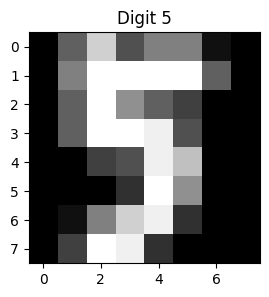

In [ ]:
k=33

fig, ax = plt.subplots(figsize=(3,3) )
ax.imshow(mnist_points[k].reshape(8,8), cmap='gray')
ax.set_title('Digit ' + str(mnist_labels[k]))
plt.show()


PCA to 3d and plot digits

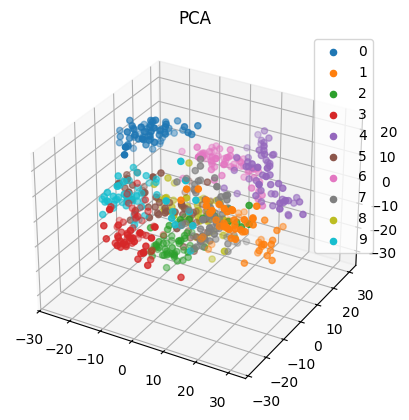

In [ ]:
pca3 = decomposition.PCA(n_components=3)
pca3.fit(mnist_points)
mnist_pca_reduced_3d = pca3.transform(mnist_points)

fig_pca = plt.figure(1)
ax_pca = fig_pca.add_subplot(111, projection='3d')
ax_pca.set_title("PCA")

for wt in range(0,len(mnist_classes_names)):
    points_pca=mnist_pca_reduced_3d[mnist_labels == wt];
    ax_pca.scatter(points_pca[:,0], points_pca[:,1], points_pca[:,2], label=mnist_classes_names[wt])

ax_pca.legend()

**MOONS dataset/distribution**

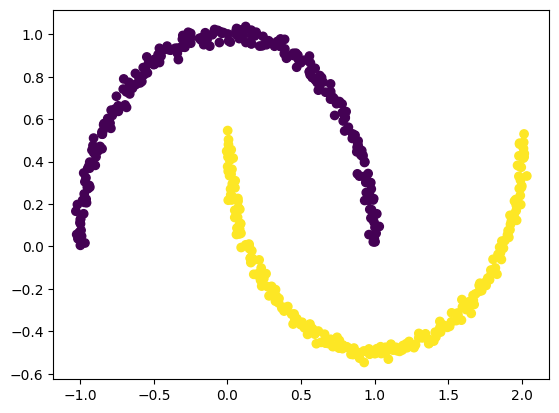

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=500, noise=0.02, random_state=417)

plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
plt.show()

PCA to 2d and 1d:

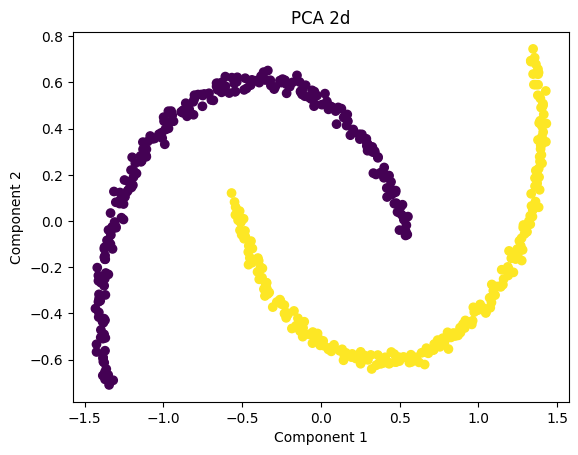

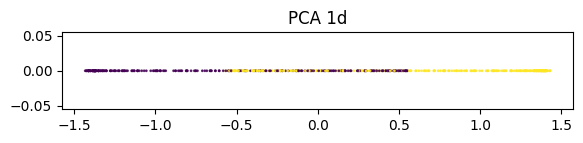

In [ ]:

pca2d = decomposition.PCA(n_components=2)
X_moons_pca2d = pca2d.fit_transform(X_moons)

plt.title("PCA 2d")
plt.scatter(X_moons_pca2d[:, 0], X_moons_pca2d[:, 1], c=y_moons)
plt.xlabel("Component 1")
plt.ylabel("Component 2")


pca1d = decomposition.PCA(n_components=1)
X_moons_pca1d = pca1d.fit_transform(X_moons)

plt.figure(figsize=(6.6,1))
plt.title("PCA 1d")
plt.scatter(X_moons_pca1d , np.zeros(X_moons_pca1d.shape[0]), c=y_moons, s=1, alpha=0.8)
plt.show()

kernelPCA to 2d and 1d

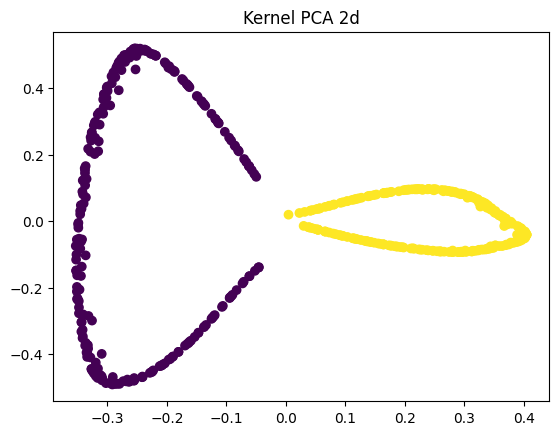

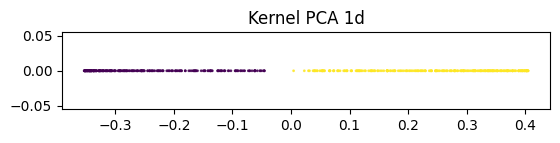

In [ ]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(kernel='rbf', gamma=15) # specific kernel with specific parameter
X_moons_kpca = kpca.fit_transform(X_moons)

plt.title("Kernel PCA 2d")
plt.scatter(X_moons_kpca[:, 0], X_moons_kpca[:, 1], c=y_moons)

plt.figure(figsize=(6.3,1))
plt.title("Kernel PCA 1d")
plt.scatter(X_moons_kpca[:, 0],  np.zeros(len(X_moons_kpca[:, 0])), c=y_moons, s=1, alpha=0.8)
plt.show()
plt.show()

**Circles**

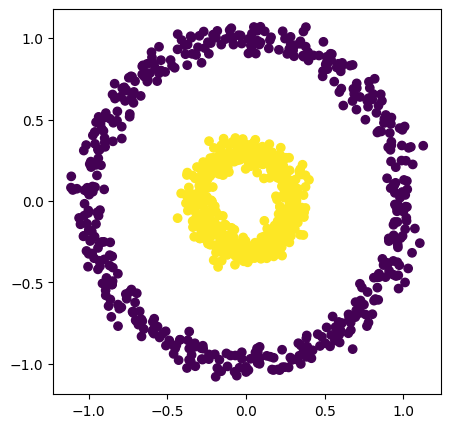

In [ ]:
from sklearn.datasets import make_circles
X_circles, y_circles = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
plt.figure(figsize=(5,5))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles)
plt.show()

## NCA (Neighborhood Component Analysis)

We are given points $\mathbf{X}=(\mathbf{x}_1,\ldots,\mathbf{x}_n)$ and $\mathbf{Y}=(y_1,\ldots,y_n)$, where $\mathbf{x}_i\in\mathbb{R}^d$ (i.e., $\mathbf{X}$ is a matrix of size $d\times n$) and corresponding classes $y_i\in\{1,\ldots,C\}$. We want to reduce the dimensionality from $d$ to $r\leq d$ via linear transformation, we transform $\mathbf{x}_i$ to $\mathbf{x}_i'$ via
$$ \mathbf{x}_i'=\mathbf{A}\mathbf{x}_i,$$
where $\mathbf{A}$ is a matrix of size $r\times d$.

Now, let $C_i$ denotes all points (indices) with label $y_i$, i.e.,
$$C_i=\{j|y_j=y_i\}$$
Define
$$f(i,j)=\exp(-||\mathbf{x}'_i-\mathbf{x_j}'||^2)=\exp(-||\mathbf{A}\mathbf{x}_i-\mathbf{A}\mathbf{x_j}||^2),$$
$$p_{ij}= {f(i,j)\over \sum_{k\neq i} f(i,k)}$$
and
$$p_i=\sum_{j\in C_i} p_{ij}.$$
The final optimization criterion is following:
$$\mathbf{A}^*=\textrm{argmax}_{\mathbf{A}} g(\mathbf{A})
=\textrm{argmin}_{\mathbf{A}} [-g(\mathbf{A})] \qquad\qquad (P1),$$
where
$$g(\mathbf{A})=\sum_{i=1}^n \sum_{j\in C_i} p_{ij} = \sum_{i=1}^n p_i.$$



The following function computes (quite effectively) loss: $-g(\mathbf{A})$:

In [ ]:

def loss_g(A, X, labels, eps=1e-12):
    """
    Computes the NCA loss for a given transformation matrix A, input data X, and labels.

    Args:
        A (torch.Tensor): Transformation matrix of shape (r, d).
        X (torch.Tensor): Data matrix of shape (d, n) where each column is a data point.
        labels (torch.Tensor): Labels tensor of shape (n,), with integer class labels.
        eps (float): A small value to prevent division by zero.

    Returns:
        torch.Tensor: The computed loss (scalar).
    """
    # Transform data: Y = A * X, resulting in shape: (r, n)
    X_prime = torch.matmul(A, X)
    X_prime_t = X_prime.t()  # shape: (n, r)

    # Compute squared Euclidean distances between all pairs of transformed points:
    # ||X_prime_i - X_prime_j||^2 = ||X_prime_i||^2 + ||X_prime_j||^2 - 2 * X_prime_i^T X_prime_j
    norm_sq = (X_prime_t ** 2).sum(dim=1, keepdim=True)  # shape: (n, 1)
    D = norm_sq + norm_sq.t() - 2 * torch.matmul(X_prime_t, X_prime_t.t())

    # Exclude self-comparison by setting the diagonal to a large value:
    n = X.shape[1]
    D = D + torch.eye(n, device=D.device) * 1e12

    # Stabilize the softmax: subtract the minimum value in each row from D.
    D_min, _ = D.min(dim=1, keepdim=True)
    D_stable = D - D_min

    # Compute the affinity using the Gaussian kernel: f(i,j) = exp(-D_stable(i,j))
    f = torch.exp(-D_stable)

    # Normalize to obtain probabilities p_{ij}
    sum_f = f.sum(dim=1, keepdim=True) + eps
    p = f / sum_f

    # Create a mask: mask[i, j] = 1 if labels[i] == labels[j], otherwise 0
    mask = (labels.unsqueeze(1) == labels.unsqueeze(0)).float()

    # Compute the objective: g(A) = sum_{i,j with same label} p_{ij}
    g_val = (p * mask).sum()

    # Since we maximize g(A), the loss is defined as the negative of g(A)
    loss = -g_val
    return loss

Lets plot the points resulting from NCA with random A and PCA:

X_mnist_torch.shape =  torch.Size([64, 600])
Loss for random A:  tensor(-186.6439)
X_mnist_torch_transf3d.shape =  torch.Size([3, 600])


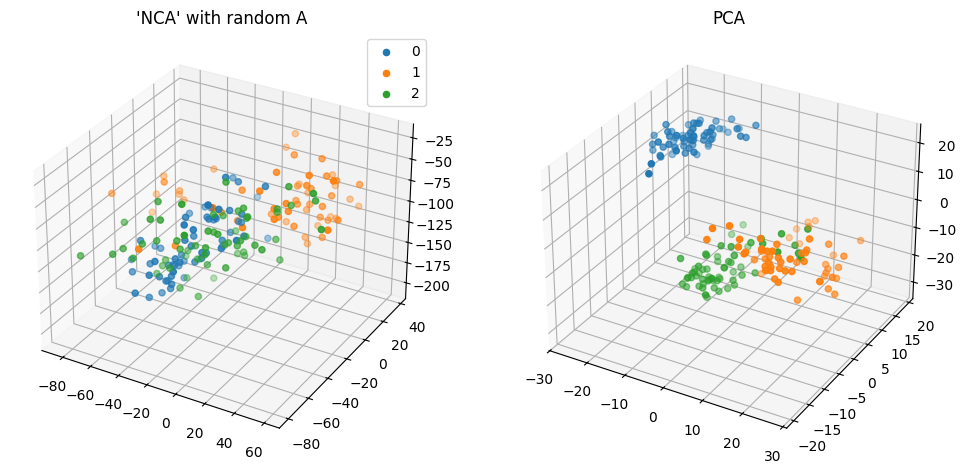

In [ ]:
X_mnist_torch = torch.tensor(mnist_points).t().float() # transpose -- since we want d times n
print("X_mnist_torch.shape = ",X_mnist_torch.shape)
d,n = X_mnist_torch.shape


#create labels tensor (using long type for comparisons)
labels = torch.tensor(mnist_labels).long()

# random A:
r=3
A_random  = torch.randn((r,d))

X_mnist_torch_transf3d = torch.matmul(A_random,X_mnist_torch)

print("Loss for random A: ", loss_g(A_random, X_mnist_torch, labels))

print("X_mnist_torch_transf3d.shape = ",X_mnist_torch_transf3d.shape)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("'NCA' with random A")

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("PCA")


Xt_rand = X_mnist_torch_transf3d.t()

for wt in range(0,len(mnist_classes_names[:3])):
    points=Xt_rand[mnist_labels == wt];
    ax1.scatter(points[:,0], points[:,1], points[:,2], label=mnist_classes_names[wt])

    points_pca=mnist_pca_reduced_3d[mnist_labels == wt];
    ax2.scatter(points_pca[:,0], points_pca[:,1], points_pca[:,2], label=mnist_classes_names[wt])


ax1.legend()
plt.show()

(Note: in above example PCA was "trained" on all data/labels, just digits 0,1,2 are shown)

# Q3.1 (**10 pts**)
* Consider MNIST dataset, but only digits 0,1,2. Perform PCA to 3d.
* NCA: optimize $(P1)$ for $\mathbf{A}$ (use Adam optimizer with `lr=0.05` for `1000` steps) to reduce points to 3d. Perform NCA with this $\mathbf{A}$.
Make three plots side-by-side: 1) NCA with "random A", 2) actual NCA, 3) PCA. Compare methods (by "eye inspection").
* Reconsider `X_circles`: convert each point $\mathbf{x}=(x,y)$ to $\mathbf{x'}=\left(x,y,\exp\left({x^2+y^2\over 1.25}\right)\right)$. Perform PCA to 1d and 2d. For 2d compare results with performing PCA and kernelPCA directly on original points.

# ICA (Independent Component Analysis)

We will start with example: Three sources, each source is a time series (thus, 1d):

(3, 1000)


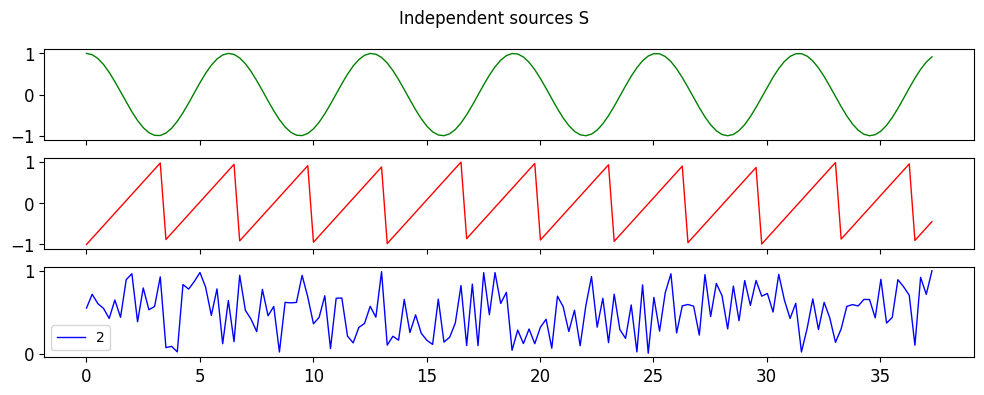

In [ ]:
import scipy

np.random.seed(0)

n=1000
grid = np.linspace(0, 250, n)

# Sources
S = np.array([np.cos(grid),                   # cos
              scipy.signal.sawtooth(grid * 1.9),      # some signal
              np.random.random(len(grid))])   # rand UNIFORM(0,1)
print(S.shape)

fig, ax = plt.subplots(3, 1, figsize=[12, 4], sharex=True)
clrs=["green","red","blue","cyan", "magenta","black"]
plt.suptitle("Independent sources S")
for i in np.arange(3):
  ax[i].plot(grid[:150], S[i,:150], lw=1,  color=clrs[i], label=str(i))
  ax[i].tick_params(labelsize=12)

plt.legend()
plt.show()

Now, we "mix" the signals using matrix A:


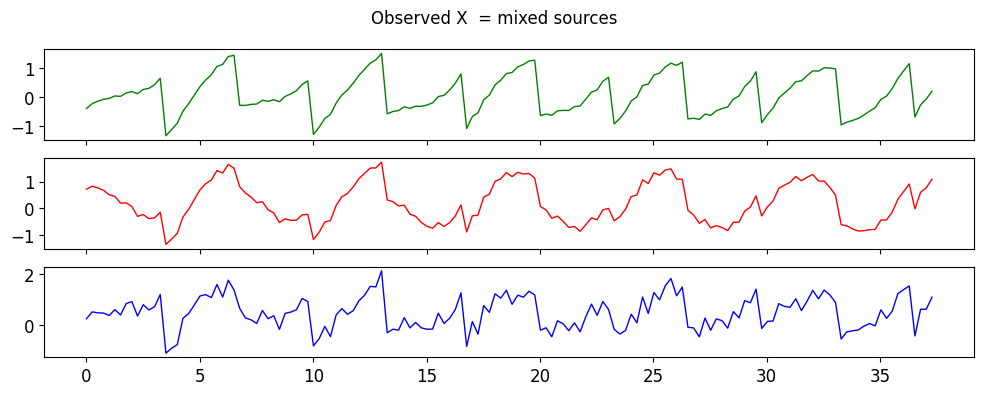

In [ ]:
# Mixing coefficients
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Observations = mixed signal
X = A.dot(S)

fig, ax = plt.subplots(3, 1, figsize=[12, 4], sharex=True)
clrs=["green","red","blue","cyan", "magenta","black"]
plt.suptitle("Observed X  = mixed sources")
for i in np.arange(3):
  ax[i].plot(grid[:150], X[i,:150], lw=1,  color=clrs[i])
  ax[i].tick_params(labelsize=12)

In [ ]:
# Compute ICA
ica = decomposition.FastICA(n_components=3, whiten='unit-variance')
S_reconstructed = ica.fit_transform(X.T).T  # Reconstruct signals
A_reconstructed = ica.mixing_  # Get estimated mixing matrix

Plot original signals vs reconstructed:


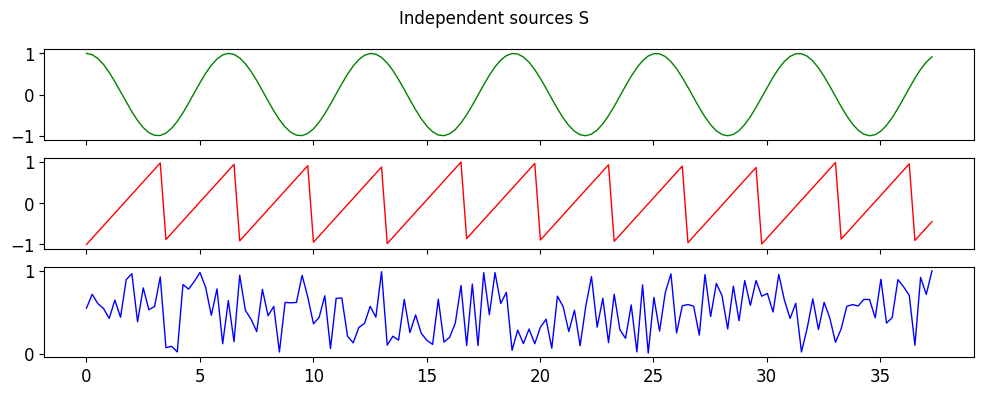

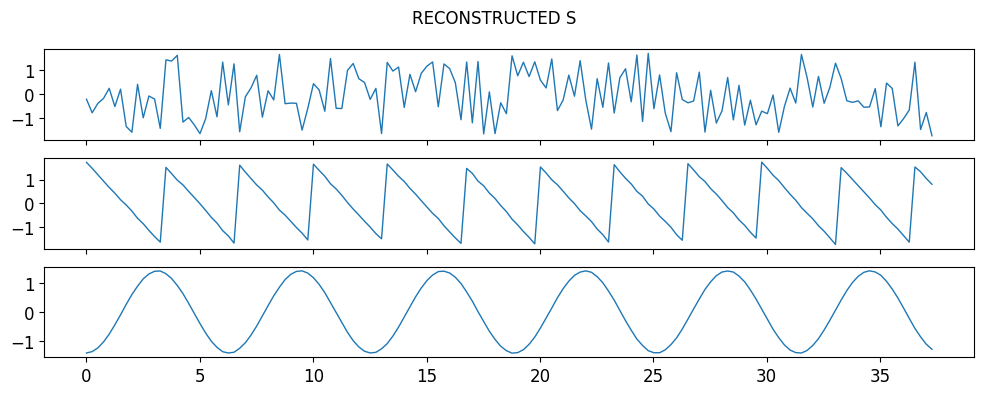

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=[12, 4], sharex=True)
clrs=["green","red","blue","cyan", "magenta","black"]
plt.suptitle("Independent sources S")
for i in np.arange(3):
  ax[i].plot(grid[:150], S[i,:150], lw=1,  color=clrs[i])
  ax[i].tick_params(labelsize=12)

plt.show()
fig, ax = plt.subplots(3, 1, figsize=[12, 4], sharex=True)
plt.suptitle("RECONSTRUCTED S")
for i in np.arange(3):
  ax[i].plot(grid[:150], S_reconstructed[i,:150], lw=1)
  ax[i].tick_params(labelsize=12)
plt.show()

Note that some signals are usuall "flipped" (in this case 1-f(x) instead of f(x)), which is common for ICA.

**Fingerprints**

Read 3 fingerprints and plot them:

In [ ]:
fp1 = img_nuclei = imageio.v3.imread('https://raw.githubusercontent.com/lorek/datasets/master/fp1.png',pilmode='L')
fp2 = img_nuclei = imageio.v3.imread('https://raw.githubusercontent.com/lorek/datasets/master/fp2.png',pilmode='L')
fp3 = img_nuclei = imageio.v3.imread('https://raw.githubusercontent.com/lorek/datasets/master/fp3.png',pilmode='L')

h,w = fp1.shape # we assume fp1,  fp2, fp3 are of the same size
n=h*w
print(h,w)


259 164


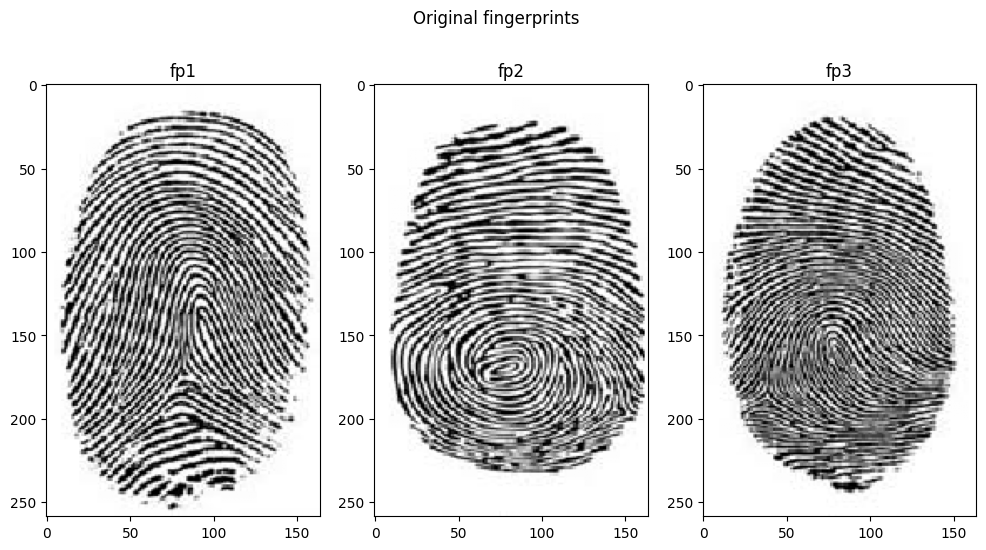

In [ ]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.imshow(fp1,cmap='gray')
ax2.imshow(fp2,cmap='gray')
ax3.imshow(fp3,cmap='gray')
ax1.set_title("fp1")
ax2.set_title("fp2")
ax3.set_title("fp3")
plt.suptitle("Original fingerprints")
plt.show()

Fingerprints displayed as time-series (aka 1D images)

<Figure size 800x400 with 0 Axes>

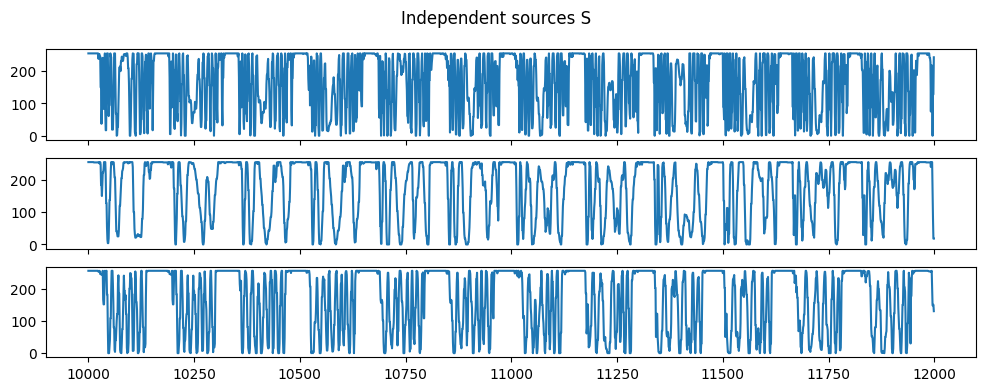

In [ ]:
fig = plt.figure(figsize=(8,4))

fig, ax = plt.subplots(3, 1, figsize=[12, 4], sharex=True)

clrs=["green","red","blue","cyan", "magenta","black"]
plt.suptitle("Independent sources S")

show_from = 10000
show_to = 12000


ax[0].plot(np.arange(show_from,show_to), fp1.reshape(-1)[show_from:show_to])
ax[1].plot(np.arange(show_from,show_to), fp2.reshape(-1)[show_from:show_to])
ax[2].plot(np.arange(show_from,show_to), fp3.reshape(-1)[show_from:show_to])


# Q3.2 (**10 pts**)
* Construct $\mathbf{S}$ of size $3\times n$, each row correspond to an image (reshaped to a vector of size $n$)
* Consider mixing matrices:
$$\mathbf{A}_1=\left[\begin{array}{llll}
5 & 10 & 0 \\
10 & 0 & 40 \\
0 & 18 & 50
\end{array}\right],\qquad  
\mathbf{A}_2=\left[\begin{array}{llll}
1 & 1 & 0 \\
0 & 1 & 1 \\
1 & 0 & 1
\end{array}\right]$$
* $\mathbf{X}=\mathbf{A} \mathbf{S}$ is a $3\times n$ matrix with mixed signals. Reshape each row of $\mathbf{X}$ back to $h\times w$ and plot as grayscale image.
* Using ICA try to reconstruct $\mathbf{S}$ from $\mathbf{X}$. Were you able to reconstruct at least one fingerprint? Try also normalizing $\mathbf{X}$ first (e.g., each row to have mean 0 and std=1). Display reconstructed sources (as images) and also as binary images (with threshold = mean of image)

# SVD

SVD manually on `baboon.bmp`

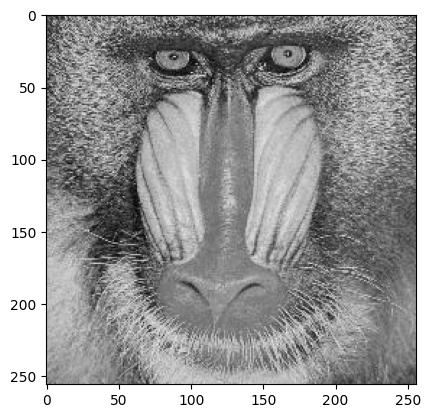

In [ ]:
img_baboon  = imageio.v3.imread('https://raw.githubusercontent.com/lorek/datasets/master/baboon.bmp',pilmode='L').astype(np.float64)
plt.imshow(img_baboon,cmap='gray')
plt.show()


In [ ]:
ZZT_eigvals  = np.linalg.eigvals(np.dot(img_baboon, img_baboon.T))

print("Sum of eigenvalues = ",np.sum(ZZT_eigvals))
ZZT_eigvals_sort  = np.sort(ZZT_eigvals)[::-1]


print("First 5 eigenvalues: ", ZZT_eigvals_sort[:5])


Sum of eigenvalues =  1195547253.0000007
First 5 eigenvalues:  [1.09854466e+09 2.28884927e+07 9.87005770e+06 4.89978496e+06
 3.33581791e+06]


But we will use built-in SVD:


In [ ]:
U,eigenvals,VT=np.linalg.svd(img_baboon)

Lambda=np.diag(eigenvals)

Lambda_sqrt=np.diag(np.sqrt(eigenvals))

In [ ]:

# reconstruct image from first k components:

def reconstr_matrix(U,D,VT,k):
    rec_mat=np.dot(U[:,:k],np.dot(D[:k,:k],VT[:k,:]))
    return rec_mat

Reconstruct images from 1,3,..,31 components:



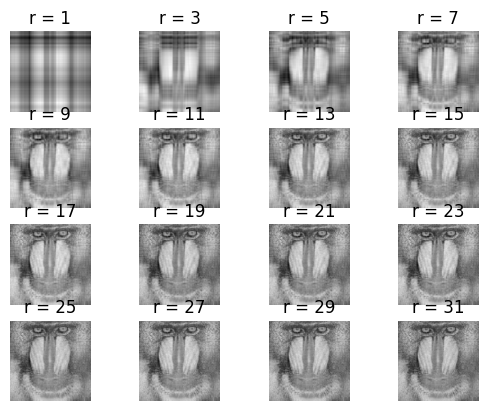

In [ ]:
nr_rows_cols=4

nr=1
how_much_rec=1
fig1=plt.figure(1);

for i in range(0,nr_rows_cols):
    for j in range(0, nr_rows_cols):
        plt.subplot(nr_rows_cols,nr_rows_cols,nr);
        rr=reconstr_matrix(U,Lambda,VT,how_much_rec)
        plt.imshow(rr, cmap=plt.get_cmap('gray'))
        plt.title("r = " + str(how_much_rec))
        plt.axis('off')
        how_much_rec+=2;
        nr+=1

**lfw PEOPLE faces** dataset:

In [ ]:
lfw_dataset = datasets.fetch_lfw_people()
# limit
max_n=1000
lfw_images =        lfw_dataset.images[:max_n]
lfw_data_classes =  lfw_dataset.target[:max_n]
lfw_classes_names  =     lfw_dataset.target_names

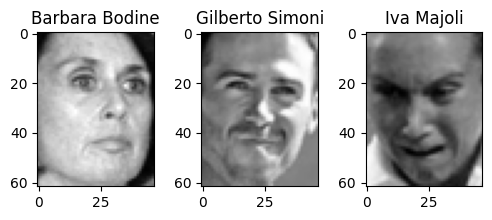

In [ ]:
plt.figure(figsize=(6,2))
plt.subplot(1,3,1);
plt.imshow(lfw_images[5], cmap='gray')
plt.title(lfw_classes_names[lfw_data_classes[5]])
plt.subplot(1,3,2);
plt.imshow(lfw_images[43], cmap='gray')
plt.title(lfw_classes_names[lfw_data_classes[43]])
plt.subplot(1,3,3);
plt.imshow(lfw_images[53], cmap='gray')
plt.title(lfw_classes_names[lfw_data_classes[53]])
plt.show()

In [ ]:
nr_of_images, height, width = lfw_images.shape
d = height*width
print("nr_of_images = ",nr_of_images, ", heigh = ", height, ", width = ", width, ", d = ",d)

nr_of_images =  1000 , heigh =  62 , width =  47 , d =  2914


# Q3.3 (**10 pts**)
* Select randomly 4 faces from `lfw`. Perform PCA on each image separately. Display images: 4 rows and 6 columnes: each row corresponds to one person, columns to recunstructed faces using $r=1,5,25,50,150$ (five columns) and for r (display its value) such that $(\lambda_1+\ldots+\lambda_r)/(\lambda_1+\ldots+\lambda_d)\geq 0.9$ (do such $r$ vary with image?)
* Collect all images in one matrix of size $d\times n$. Perform PCA on such matrix. Then "recover" faces of 4 persons (the same as in previous case) using $r=1,5,25,50,150$ and common $r$ such that $(\lambda_1+\ldots+\lambda_r)/(\lambda_1+\ldots+\lambda_d)\geq 0.9$